# Auto-cross-correlogram

In [13]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
#from fitting_functions import cross_validate_model
#from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

one = ONE()

## Parameters

In [7]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [8]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

## PCA on data samples

In [9]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = matrix_all[mat][0] # (n_samples, n_features)
#X = np.array(design_matrix)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))


Text(0, 0.5, '% Variance explained')

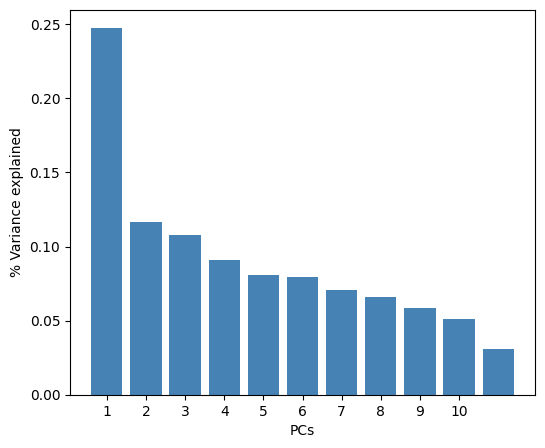

In [10]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

In [11]:
# Normalize PC projections
scaler = StandardScaler()

# Fit and transform the data
normalized_projections = scaler.fit_transform(X_reduced)  # TODO: is projections the accurate term here?
#normalized_projections = scaler.fit_transform(X)


### Get bin information

In [12]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['Bin'], index=range(len(normalized_projections)))
augmented_data['Bin'] = design_matrix['Bin']
augmented_data['pc1'] = normalized_projections[:, 0].transpose()
augmented_data['pc2'] = normalized_projections[:, 1].transpose()
augmented_data['pc3'] = normalized_projections[:, 2].transpose()
augmented_data['pc4'] = normalized_projections[:, 3].transpose()
augmented_data['pc5'] = normalized_projections[:, 4].transpose()
augmented_data['pc6'] = normalized_projections[:, 5].transpose()
augmented_data['pc7'] = normalized_projections[:, 6].transpose()
augmented_data['pc8'] = normalized_projections[:, 7].transpose()
augmented_data['pc9'] = normalized_projections[:, 8].transpose()
augmented_data['pc10'] = normalized_projections[:, 9].transpose()

### TODO:
- average correlation of all dimensions
- different lags

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_13403/507009570.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


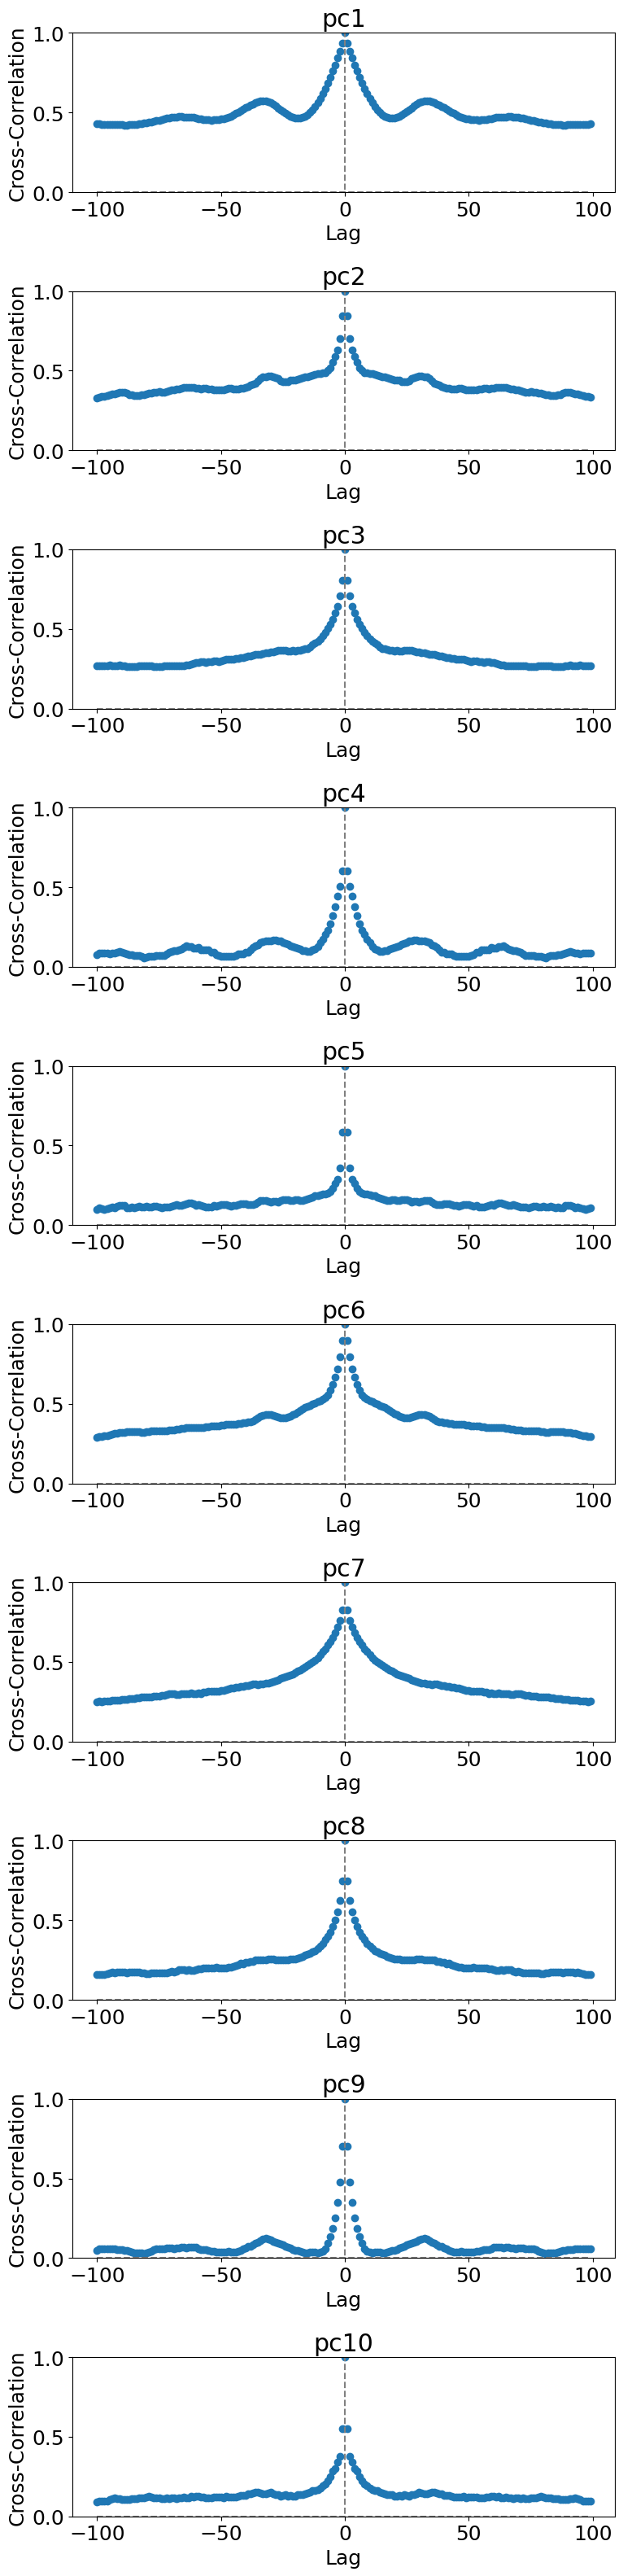

(0.0, 35.0)

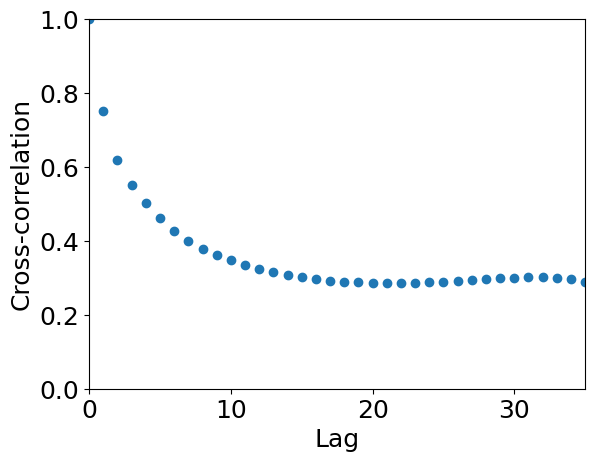

In [31]:
pcs = augmented_data.keys()[1:]
lags_to_plot = 100

fig, ax = plt.subplots(nrows=len(pcs) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])

corrs = []

for i, pc in enumerate(pcs):
    
    x = augmented_data[pc]

    # Calculate the lag values corresponding to the cross-correlation
    lags = np.arange(-lags_to_plot, lags_to_plot)

    # Compute the cross-correlation using np.correlate
    cross_correlation = np.zeros(len(lags)) * np.nan
    len_timeseries = len(x)
    for l, lag in enumerate(lags):
        if lag < 0:
            x_chunk = np.array(x[-lag:])
            y_chunk = np.array(x[:lag])
        elif lag == 0:
            x_chunk = np.array(x)
            y_chunk = np.array(x)
        elif lag > 0:
            x_chunk = np.array(x[0:-lag])
            y_chunk = np.array(x[lag:])
        cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic

    # Save data
    if i == 0:
        corrs = [cross_correlation]
    else:
        corrs = np.vstack((corrs, cross_correlation))

    # Plot the cross-correlation
    ax[i].scatter(lags, cross_correlation)
    ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
    ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
    ax[i].set_xlabel('Lag')
    ax[i].set_ylabel('Cross-Correlation')
    ax[i].set_title(pc)
    ax[i].set_ylim([0, 1])
            
    plt.tight_layout()
plt.show()

plt.scatter(lags, np.mean(corrs, axis=0))
plt.ylim([0, 1])
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xlim([0, 35])
